<a href="https://colab.research.google.com/github/allthemod/people-counter/blob/main/poeplecounter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python
!pip install urllib3
!pip install pytube
!pip install ultralytics==8.0.196
!pip install requests
!pip install imutils
!pip install dlib
!pip install scipy
!pip install face-recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=9ee363cdfdcde5d190b2207689b2be190973be940628c74b2a67aa36bff4c924
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
!pip show face-recognition

Name: face-recognition
Version: 1.3.0
Summary: Recognize faces from Python or from the command line
Home-page: https://github.com/ageitgey/face_recognition
Author: Adam Geitgey
Author-email: ageitgey@gmail.com
License: MIT license
Location: /usr/local/lib/python3.10/dist-packages
Requires: Click, dlib, face-recognition-models, numpy, Pillow
Required-by: 


In [ ]:
import cv2
import urllib.request
from pytube import YouTube
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import logging

from IPython.display import display, Image, clear_output
import requests
from scipy.spatial import distance as dist
from collections import OrderedDict
import numpy as np
import imutils
import time
import dlib
try:
  import face_recognition
except RuntimeError:
  logging.warning(f"No face_recognition, cuda drivers are not functioning")

size = (640, 640)

In [ ]:
test = OrderedDict([(1, [list([241, 436]), None])])
test[0][0]

KeyError: 0

In [ ]:
type(None)

NoneType

In [ ]:
image = face_recognition.load_image_file("biden.jpg")

# Find all the faces in the image using the default HOG-based model.
# This method is fairly accurate, but not as accurate as the CNN model and not GPU accelerated.
# See also: find_faces_in_picture_cnn.py
face_locations = face_recognition.face_locations(image)
encodings = face_recognition.face_encodings(image, face_locations)
np.array(face_locations).shape

(1, 4)

In [ ]:

class PersonTracker:
  @staticmethod
  def computeClosestToAndUnrelated(pointsA:np.ndarray, pointsB:np.ndarray, maxDis=float('inf')): #for example centroid(n,2) and points(m,2)
      # #make sure you get the smallest distance for each point
      # if pointsA.shape[0] <  pointsB.shape[0]:
      #   temp = pointsA
      #   pointsA = pointsB
      #   pointsB = temp
      D = dist.cdist(pointsA, pointsB) #array of shape (n, m) [point1[all the combinations withe the b points] ]

      #  1  2  3
      #1 y  n  n
      #2 n  y  n
      #3 n  n  y
      rows = D.min(axis=1).argsort() # [min of([0,1,2,3]), [0,1,2,3(then we replace the numbers by the indexes instead)]] shape of (n,) [point a index of which has th leeeast distance to a point b]
      cols = D.argmin(axis=1)[rows] # [min, min, min] and reversed shape of (n,) [which point b was with the least distance]
      usedRows = set()
      usedCols = set()
      matches = {}
			# loop over the combination of the (row, column) index
			# tuples
      for (i,(row, col)) in enumerate(zip(rows, cols)):
				# if we have already examined either the row or
				# column value before, ignore it
				# val
        if row in usedRows or col in usedCols:
          continue
				# otherwise, grab the object ID for the current row,
				# set its new centroid, and reset the disappeared
				# counter
        matches[i] = col
				# indicate that we have examined each of the row and
				# column indexes, respectively
        usedRows.add(row)
        usedCols.add(col)
      unusedRows = set(range(0, D.shape[0])).difference(usedRows)
      #unusedCols = set(range(0, D.shape[1])).difference(usedCols)
      return matches, unusedRows

  def calcCentroids(self, rects):
        inputCentroids = np.zeros((len(rects), 2), dtype="int")

        # loop over the bounding box rectangles
        for (i, (startX, startY, endX, endY)) in enumerate(rects):
          # use the bounding box coordinates to derive the centroid
          cX = int((startX + endX) / 2.0)
          cY = int((startY + endY) / 2.0)
          inputCentroids[i] = (cX, cY)
        return inputCentroids




  def __init__(self, maxDisappeared=50):

      self.nextObjectID = 0
      self.objects = OrderedDict()
      self.disappeared = OrderedDict()
      self.facesAndObjectIds = OrderedDict() #{"objectid":faceEncoding}
      self.maxDis = 0
      self.maxDisappeared = maxDisappeared


  def register(self, centroid, faceEncode=None):
      # when registering an object we use the next available object
      # ID to store the centroid
      id = None
      if not isinstance(faceEncode, type(None)) and any(face_recognition.compare_faces(faceEncode, self.getAllExitingFaces())):
        comp = face_recognition.compare_faces(faceEncode, self.getAllExitingFaces())
        trueIndexes =  [i for i,x in enumerate(comp) if x]
        id = list(self.facesAndObjectIds.keys())[trueIndexes[0]]
      self.objects[self.nextObjectID if None is id else id] = [centroid, faceEncode]
      self.disappeared[self.nextObjectID if None is id else id] = 0
      if None is id:
        self.nextObjectID += 1

  def deregister(self, objectID):

    # to deregister an object ID we delete the object ID from
    # both of our respective dictionaries
    del self.objects[objectID]
    del self.disappeared[objectID]

  def updateObjectWithExitingFace(self, face, objectid):
    cen = self.objects[objectid][0]
    self.objects.pop(objectid)
    self.register(cen, faceEncode=face)
  def getObjectsCent(self):
    if len(self.objects) == 0:
      return np.array([])

    return np.array([x[0] for x in self.objects.values()])
  def getAllExitingFaces(self):
    return [x for x in self.facesAndObjectIds.values()]
  def registerFace(self, faceEncoding):
    self.facesAndObjectIds[self.nextObjectID] = faceEncoding
    self.nextObjectID += 1
  def getIndexToIdDict(self):
    if len(self.objects) == 0:
      return {}

    return {i : x for i,x in enumerate(self.objects.keys())}


  def update(self, reacts, faceEncodings, facelocations) -> OrderedDict:
      #TODO: add distance tracket to track wich object is closest to which rect and match the object with the face rec
      #break down:
      for face in faceEncodings:
        if len(self.getAllExitingFaces()) == 0:
          self.registerFace(face)
          continue
        if face.shape[0] >0 and not any(face_recognition.compare_faces(face, self.getAllExitingFaces())):
          self.registerFace(face)

      inputCentroids = self.calcCentroids(reacts)
      if len(reacts) == 0:
        # loop over any existing tracked objects and mark them
        # as disappeared
        for objectID in list(self.disappeared.keys()):
          self.disappeared[objectID] += 1
          print(f"disssssssssssssssssssssssssssssssssssssssssss {self.disappeared[objectID]}")

          # if we have reached a maximum number of consecutive
          # frames where a given object has been marked as
          # missing, deregister it
          if self.disappeared[objectID] > self.maxDisappeared:
            self.deregister(objectID)

        # return early as there are no centroids or tracking info
        # to update
        return self.objects
      else:
        pointToId = []
        if self.getObjectsCent().shape[0] != 0:
          matches, unused = PersonTracker.computeClosestToAndUnrelated(inputCentroids, self.getObjectsCent())
          pointToId = self.getIndexToIdDict()
          for unusedObject in unused:
            id = pointToId[unusedObject]
            self.disappeared[id] += 1
            print(f"disssssssssssssssssssssssssssssssssssssssssss {self.disappeared[id]}")
            if self.disappeared[objectID] > self.maxDisappeared:
              self.deregister(objectID)
        else:
          matches = {}

        faceLocMatches = None
        if facelocations.shape[0] <= inputCentroids.shape[0] and facelocations.shape[0] !=0:
          faceLocMatches, _ = PersonTracker.computeClosestToAndUnrelated(self.calcCentroids(facelocations) , inputCentroids)
        for i in range(inputCentroids.shape[0]):
          encoding = None
          if not i in matches.keys():

            if faceLocMatches and i in faceLocMatches.values():
              encoding = list(faceLocMatches.keys())[list(faceLocMatches.values()).index(i)]
            if encoding != None and faceEncodings[encoding].shape[0] > 0 and any(face_recognition.compare_faces(faceEncodings[encoding], self.getAllExitingFaces())):
              comparsion = face_recognition.compare_faces(faceEncodings[encoding], self.getAllExitingFaces())
            self.register(inputCentroids[i], faceEncodings[encoding] if encoding else None)
          else:
           self.objects[pointToId[i]][0] = inputCentroids[i]

           if not isinstance(self.objects[pointToId[i]][1] == None, list):
              if faceLocMatches != None and i in faceLocMatches.values():
                encoding = list(faceLocMatches.keys())[list(faceLocMatches.values()).index(i)]
                self.updateObjectWithExitingFace(faceEncodings[encoding], pointToId[i])
      return self.objects



In [ ]:
class CentroidTracker:
	def __init__(self, maxDisappeared=50, maxDistance=50):
		# initialize the next unique object ID along with two ordered
		# dictionaries used to keep track of mapping a given object
		# ID to its centroid and number of consecutive frames it has
		# been marked as "disappeared", respectively
		self.nextObjectID = 0
		self.objects = OrderedDict()
		self.disappeared = OrderedDict()

		# store the number of maximum consecutive frames a given
		# object is allowed to be marked as "disappeared" until we
		# need to deregister the object from tracking
		self.maxDisappeared = maxDisappeared

		# store the maximum distance between centroids to associate
		# an object -- if the distance is larger than this maximum
		# distance we'll start to mark the object as "disappeared"
		self.maxDistance = maxDistance

	def register(self, centroid):
		# when registering an object we use the next available object
		# ID to store the centroid
		self.objects[self.nextObjectID] = centroid
		self.disappeared[self.nextObjectID] = 0
		self.nextObjectID += 1

	def deregister(self, objectID):
		# to deregister an object ID we delete the object ID from
		# both of our respective dictionaries
		del self.objects[objectID]
		del self.disappeared[objectID]

	def update(self, rects):
		# check to see if the list of input bounding box rectangles
		# is empty
		if len(rects) == 0:

			# loop over any existing tracked objects and mark them
			# as disappeared
			for objectID in list(self.disappeared.keys()):
				self.disappeared[objectID] += 1

				# if we have reached a maximum number of consecutive
				# frames where a given object has been marked as
				# missing, deregister it
				if self.disappeared[objectID] > self.maxDisappeared:
					self.deregister(objectID)

			# return early as there are no centroids or tracking info
			# to update
			return self.objects

		# initialize an array of input centroids for the current frame
		inputCentroids = np.zeros((len(rects), 2), dtype="int")

		# loop over the bounding box rectangles
		for (i, (startX, startY, endX, endY)) in enumerate(rects):
			# use the bounding box coordinates to derive the centroid
			cX = int((startX + endX) / 2.0)
			cY = int((startY + endY) / 2.0)
			inputCentroids[i] = (cX, cY)

		# if we are currently not tracking any objects take the input
		# centroids and register each of them
		if len(self.objects) == 0:
			for i in range(0, len(inputCentroids)):
				self.register(inputCentroids[i])

		# otherwise, are are currently tracking objects so we need to
		# try to match the input centroids to existing object
		# centroids
		else:
			# grab the set of object IDs and corresponding centroids
			objectIDs = list(self.objects.keys())
			objectCentroids = list(self.objects.values())

			# compute the distance between each pair of object
			# centroids and input centroids, respectively -- our
			# goal will be to match an input centroid to an existing
			# object centroid
			D = dist.cdist(np.array(objectCentroids), inputCentroids)

			# in order to perform this matching we must (1) find the
			# smallest value in each row and then (2) sort the row
			# indexes based on their minimum values so that the row
			# with the smallest value as at the *front* of the index
			# list

			rows = D.min(axis=1).argsort()



			# next, we perform a similar process on the columns by
			# finding the smallest value in each column and then
			# sorting using the previously computed row index list
			cols = D.argmin(axis=1)[rows]


			# in order to determine if we need to update, register,
			# or deregister an object we need to keep track of which
			# of the rows and column indexes we have already examined
			usedRows = set()
			usedCols = set()

			# loop over the combination of the (row, column) index
			# tuples
			for (row, col) in zip(rows, cols):
				# if we have already examined either the row or
				# column value before, ignore it
				if row in usedRows or col in usedCols:
					continue

				# if the distance between centroids is greater than
				# the maximum distance, do not associate the two
				# centroids to the same object
				if D[row, col] > self.maxDistance:
					continue

				# otherwise, grab the object ID for the current row,
				# set its new centroid, and reset the disappeared
				# counter
				objectID = objectIDs[row]
				self.objects[objectID] = inputCentroids[col]
				self.disappeared[objectID] = 0

				# indicate that we have examined each of the row and
				# column indexes, respectively
				usedRows.add(row)
				usedCols.add(col)

			# compute both the row and column index we have NOT yet
			# examined
			unusedRows = set(range(0, D.shape[0])).difference(usedRows)
			unusedCols = set(range(0, D.shape[1])).difference(usedCols)

			# in the event that the number of object centroids is
			# equal or greater than the number of input centroids
			# we need to check and see if some of these objects have
			# potentially disappeared
			if D.shape[0] >= D.shape[1]:
				# loop over the unused row indexes
				for row in unusedRows:
					# grab the object ID for the corresponding row
					# index and increment the disappeared counter
					objectID = objectIDs[row]
					self.disappeared[objectID] += 1

					# check to see if the number of consecutive
					# frames the object has been marked "disappeared"
					# for warrants deregistering the object
					if self.disappeared[objectID] > self.maxDisappeared:
						self.deregister(objectID)

			# otherwise, if the number of input centroids is greater
			# than the number of existing object centroids we need to
			# register each new input centroid as a trackable object
			else:
				for col in unusedCols:
					self.register(inputCentroids[col])

		# return the set of trackable objects
		return self.objects

In [ ]:
class TrackableObject:
	def __init__(self, objectID, centroid):
		# store the object ID, then initialize a list of centroids
		# using the current centroid
		self.objectID = objectID
		self.centroids = [centroid]

		# initialize a boolean used to indicate if the object has
		# already been counted or not
		self.counted = False

In [ ]:
import argparse

import cv2.dnn
import numpy as np

from ultralytics.utils import ASSETS, yaml_load
from ultralytics.utils.checks import check_yaml

CLASSES = yaml_load(check_yaml("coco128.yaml"))["names"]
colors = np.random.uniform(0, 255, size=(len(CLASSES), 3))


def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):
    """
    Draws bounding boxes on the input image based on the provided arguments.

    Args:
        img (numpy.ndarray): The input image to draw the bounding box on.
        class_id (int): Class ID of the detected object.
        confidence (float): Confidence score of the detected object.
        x (int): X-coordinate of the top-left corner of the bounding box.
        y (int): Y-coordinate of the top-left corner of the bounding box.
        x_plus_w (int): X-coordinate of the bottom-right corner of the bounding box.
        y_plus_h (int): Y-coordinate of the bottom-right corner of the bounding box.
    """
    label = f"{CLASSES[class_id]} ({confidence:.2f})"
    color = colors[class_id]
    cv2.rectangle(img, (x, y), (x_plus_w, y_plus_h), color, 2)
    cv2.putText(img, label, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


def main(onnx_model, input_image):
    """
    Main function to load ONNX model, perform inference, draw bounding boxes, and display the output image.

    Args:
        onnx_model (str): Path to the ONNX model.
        input_image (str): Path to the input image.

    Returns:
        list: List of dictionaries containing detection information such as class_id, class_name, confidence, etc.
    """
    # Load the ONNX model
    model: cv2.dnn.Net = onnx_model

    # Read the input image
    original_image: np.ndarray = input_image
    [height, width, _] = original_image.shape

    # Prepare a square image for inference
    length = max((height, width))
    image = np.zeros((length, length, 3), np.uint8)
    image[0:height, 0:width] = original_image

    # Calculate scale factor
    scale = length / size[0]

    # Preprocess the image and prepare blob for model
    blob = cv2.dnn.blobFromImage(image, scalefactor=1 / 255, size=size, swapRB=True)
    model.setInput(blob)

    # Perform inference
    outputs = model.forward()

    # Prepare output array
    outputs = np.array([cv2.transpose(outputs[0])])
    rows = outputs.shape[1]

    boxes = []
    scores = []
    class_ids = []

    # Iterate through output to collect bounding boxes, confidence scores, and class IDs
    for i in range(rows):
        classes_scores = outputs[0][i][4:]
        (minScore, maxScore, minClassLoc, (x, maxClassIndex)) = cv2.minMaxLoc(classes_scores)
        if maxScore >= 0.25:
            box = [
                outputs[0][i][0] - (0.5 * outputs[0][i][2]),
                outputs[0][i][1] - (0.5 * outputs[0][i][3]),
                outputs[0][i][2],
                outputs[0][i][3],
            ]
            boxes.append(box)
            scores.append(maxScore)
            class_ids.append(maxClassIndex)

    # Apply NMS (Non-maximum suppression)
    result_boxes = cv2.dnn.NMSBoxes(boxes, scores, 0.25, 0.45, 0.5)

    detections = []

    # Iterate through NMS results to draw bounding boxes and labels
    for i in range(len(result_boxes)):
        index = result_boxes[i]
        box = boxes[index]
        detection = {
            "class_id": class_ids[index],
            "class_name": CLASSES[class_ids[index]],
            "confidence": scores[index],
            "box": box,
            "scale": scale,
        }
        detections.append(detection)
        draw_bounding_box(
            original_image,
            class_ids[index],
            scores[index],
            round(box[0] * scale),
            round(box[1] * scale),
            round((box[0] + box[2]) * scale),
            round((box[1] + box[3]) * scale),
        )

    # Display the image with bounding boxes
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    return detections

In [ ]:
model = YOLO("yolov8m.pt")
model.export(format="onnx", imgsz=list(size))
def Download(link):
    youtubeObject = YouTube(link)
    youtubeObject = youtubeObject.streams.get_highest_resolution()
    try:
        youtubeObject.download(filename="video.mp4")
    except:
        print("An error has occurred")
    print("Download is completed successfully")
def download_mp4(url):
    destination = "video.mp4"
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(destination, 'wb') as file:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file.write(chunk)
        print(f"Download successful. Saved to {destination}")
    else:
        print(f"Failed to download. Status code: {response.status_code}")

100%|██████████| 49.7M/49.7M [00:00<00:00, 211MB/s]
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.30GHz)
YOLOv8m summary (fused): 218 layers, 25886080 parameters, 0 gradients, 78.9 GFLOPs

PyTorch: starting from 'yolov8m.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (49.7 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 98.7 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 8.9s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.15.0 opset 17...
ONNX: export success ✅ 12.9s, saved as 'yolov8m.onnx' (99.0 MB)

Export complete (19.4s)
Results saved to /content
Predict:         yolo predict task=detect model=yolov8m.onnx imgsz=640  
Validate:        yolo val task=detect model=yolov8m.onnx imgsz=640 data=coco.yaml  
Visual

In [ ]:
# prompt: load a youtube by a url to open cv

#https://www.freecodecamp.org/news/python-program-to-download-youtube-videos/

url = 'https://www.youtube.com/watch?v=dQw4w9WgXcQ'



Download(url)

Download is completed successfully


In [ ]:
url = "https://download1584.mediafire.com/lshwv32r9tog-bklG32knyBp1ARQtFtjDxh_tz3KxqHU07cEd2k1wV9JbCigpQcSjmcIMYZme5gVGEMSWy6prWvpP37zsFNIAzV5uI8njoXKZOvQ2vJOnkEK-myceyi5H3vpxuESCz-Uu8RjP4d6CW2bYhEfCedpTKHTIvV2knq5kg/8k10xgbx6t04wsa/example_01.mp4"

download_mp4(url)

Download successful. Saved to video.mp4


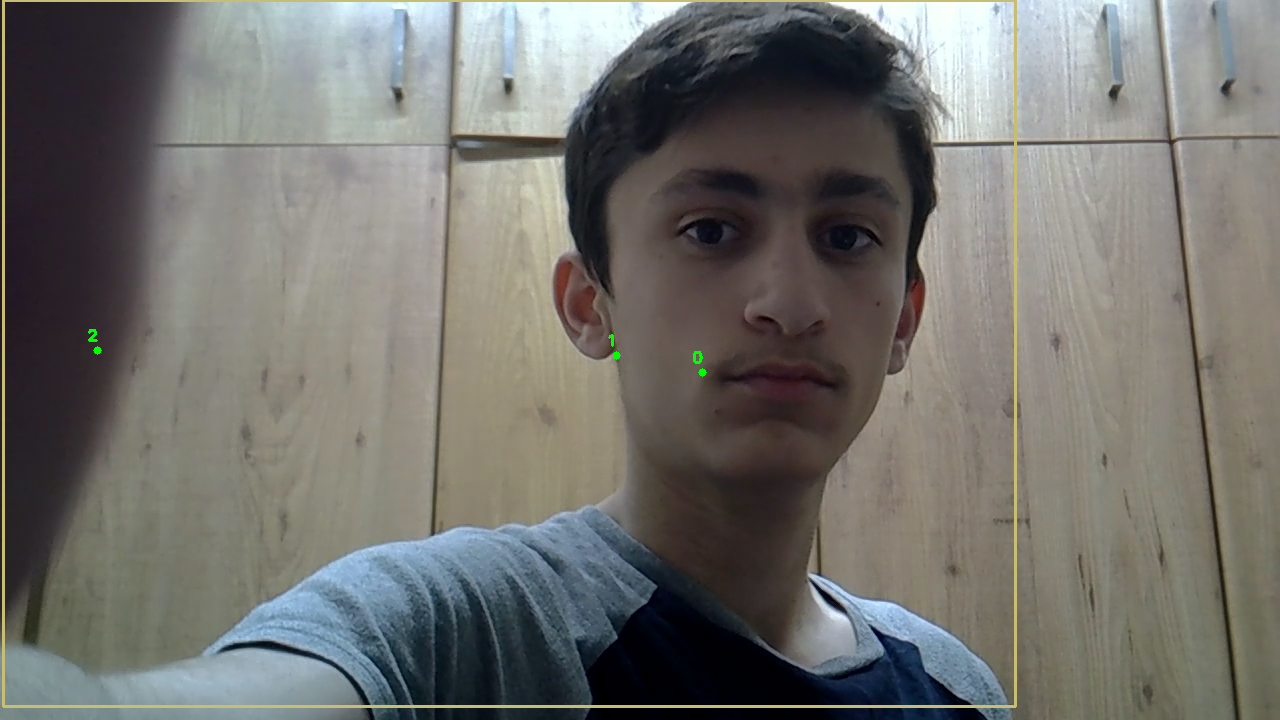

KeyboardInterrupt: 

In [ ]:


ct = CentroidTracker(maxDisappeared=40, maxDistance=50)
trackers = []
trackableObjects = {}
skip_frames = 3
totalFrames = 0
model = cv2.dnn.readNetFromONNX("yolov8m.onnx")

# initialize the total number of frames processed thus far, along
# with the total number of objects that have moved either up or down
cap = cv2.VideoCapture('video.mp4')
while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        rects = []
        if totalFrames % skip_frames == 0:
          trackers = []
          #frame = cv2.resize(frame, size)
          rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB).copy()
          detections = main(model,frame)

          for detection in detections:
              if detection["class_id"] != 0: #person
                continue
              box = detection["box"]
              scale = detection["scale"]
              tracker = dlib.correlation_tracker()
              rect = dlib.rectangle(round(box[0] * scale),
            round(box[1] * scale),
            round((box[0] + box[2]) * scale),
            round((box[1] + box[3]) * scale))
              tracker.start_track(rgb, rect)

              # add the tracker to our list of trackers so we can
              # utilize it during skip frames
              trackers.append(tracker)
          else:
            # loop over the trackers
            for tracker in trackers:
              # set the status of our system to be 'tracking' rather
              # than 'waiting' or 'detecting'
              status = "Tracking"

              # update the tracker and grab the updated position
              tracker.update(rgb)
              pos = tracker.get_position()

              # unpack the position object
              startX = int(pos.left())
              startY = int(pos.top())
              endX = int(pos.right())
              endY = int(pos.bottom())

              # add the bounding box coordinates to the rectangles list
              rects.append((startX, startY, endX, endY))
          objects = ct.update(rects)
          for (objectID, centroid) in objects.items():
            # check to see if a trackable object exists for the current
            # object ID
            to = trackableObjects.get(objectID, None)

            # if there is no existing trackable object, create one
            if to is None:
              to = TrackableObject(objectID, centroid)
            cv2.putText(frame, str(objectID), (centroid[0] - 10, centroid[1] - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            cv2.circle(frame, (centroid[0], centroid[1]), 4, (0, 255, 0), -1)
          clear_output(wait=True)
          cv2_imshow(frame)
          if cv2.waitKey(1) & 0xFF == ord('q'):
              break
        else:
          pass
cap.release()
cv2.destroyAllWindows()


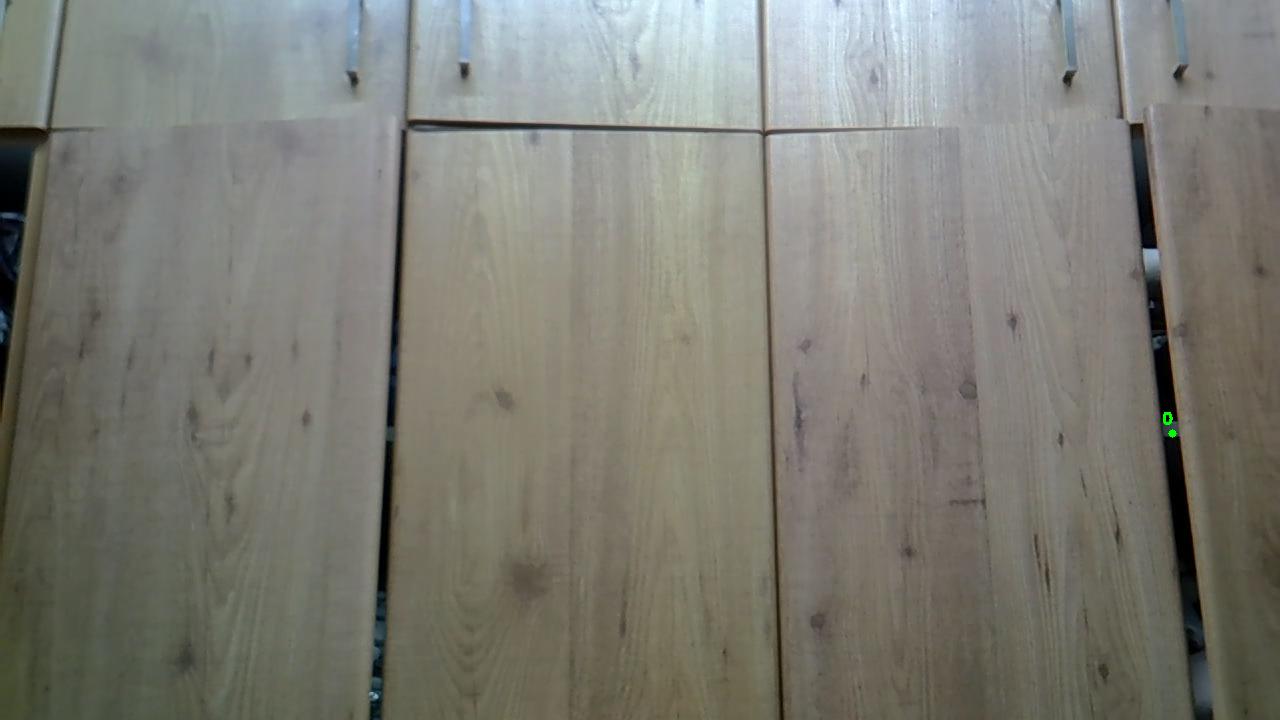

disssssssssssssssssssssssssssssssssssssssssss 21


KeyError: 1

In [ ]:


ct = PersonTracker(20)
skip_frames = 20
totalFrames = 0
model = cv2.dnn.readNetFromONNX("yolov8m.onnx")
trackers = []

# initialize the total number of frames processed thus far, along
# with the total number of objects that have moved either up or down
cap = cv2.VideoCapture('video.mp4')
while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        rects = []
        if totalFrames % skip_frames == 0:
          trackers = []
          #frame = cv2.resize(frame, size)
          rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB).copy()
          detections = main(model,frame)

          for detection in detections:
              if detection["class_id"] != 0: #person
                continue
              box = detection["box"]
              scale = detection["scale"]
              tracker = dlib.correlation_tracker()
              rect = dlib.rectangle(round(box[0] * scale),
             round(box[1] * scale),
             round((box[0] + box[2]) * scale),
             round((box[1] + box[3]) * scale))
              rects.append((round(box[0] * scale),
            round(box[1] * scale),
            round((box[0] + box[2]) * scale),
            round((box[1] + box[3]) * scale)))
              tracker.start_track(rgb, rect)

              # add the tracker to our list of trackers so we can
              # utilize it during skip frames
              trackers.append(tracker)
        else:
            # loop over the trackers
            for tracker in trackers:
              # set the status of our system to be 'tracking' rather
              # than 'waiting' or 'detecting'
              status = "Tracking"

              # update the tracker and grab the updated position
              tracker.update(rgb)
              pos = tracker.get_position()

              # unpack the position object
              startX = int(pos.left())
              startY = int(pos.top())
              endX = int(pos.right())
              endY = int(pos.bottom())

              # add the bounding box coordinates to the rectangles list
              rects.append((startX, startY, endX, endY))
        face_locations = face_recognition.face_locations(frame)
        encodings = face_recognition.face_encodings(frame, face_locations)
        face_locations = np.array(face_locations)
        objects = ct.update(rects, facelocations=face_locations, faceEncodings= encodings)
        if len(objects) != 0:
          for (objectID, (centroid,faceEncoding)) in objects.items():
            cv2.putText(frame, str(objectID), (centroid[0] - 10, centroid[1] - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            cv2.circle(frame, (centroid[0], centroid[1]), 4, (0, 255, 0), -1)
        clear_output(wait=True)
        cv2_imshow(frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()
